In [262]:
#most important library required for the classification 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV,train_test_split,GridSearchCV,StratifiedKFold
from sklearn import datasets,metrics
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import seaborn as sns

In [263]:
#  ***loading_datasets***

#loading breast cancer data from the irish dataset
data=datasets.load_breast_cancer() 

#these are the x1,x2,x3....... or features  which we will use for training and predection
x_value=data.data 

#this is the target value i.e coresponding value for each row of feature indicating either the preson have cancer or not
y_value=data.target 
print(x_value.shape,y_value.shape)

(569, 30) (569,)


In [264]:
def class_visulizer(y_value):
    #class visualization
    unique,counts=np.unique(y_value,return_counts=True)
    plt.figure(figsize=(3,2))
    plt.bar(unique,counts)
    plt.xlabel('numbers')
    plt.ylabel('counts')
    plt.title('number vs count')
    plt.show()

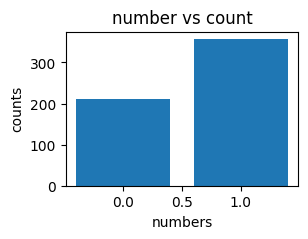

In [265]:
class_visulizer(y_value)

In [266]:
def data_splitter(x_value,y_value):
    #above data shows the data seems be unequal on different class so lets stratify and split them  .
    x_train,x_test,y_train,y_test=train_test_split(x_value,y_value ,test_size=0.3,stratify=y_value,shuffle=True)
    #now lets calculate the corelation of each feature with target value 
    print(type(x_value))
    #lets convert this into panda dataframe for proper manupulation of data 
    return x_train,x_test,y_train,y_test

In [267]:
x_train,x_test,y_train,y_test=data_splitter(x_value,y_value)

<class 'numpy.ndarray'>


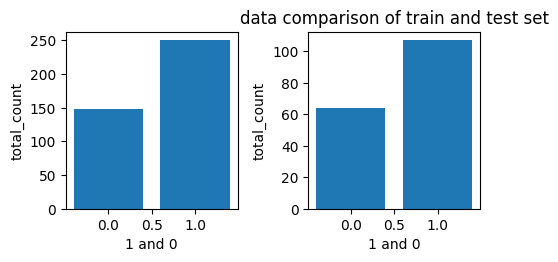

In [268]:
#checking the distribution of of the x_train and y_test 
fig,ax=plt.subplots(1,2,figsize=(5,2.5))
unique,counts=np.unique(y_train,return_counts=True)
unique1,counts1=np.unique(y_test,return_counts=True)
ax[0].bar(unique,counts)
ax[0].set_xlabel('1 and 0')
ax[0].set_ylabel('total_count')

ax[1].bar(unique1,counts1)
ax[1].set_xlabel('1 and 0')
ax[1].set_ylabel('total_count')
plt.tight_layout()
plt.title('data comparison of train and test set')
plt.show()

In [269]:
def corelation_finder(data):
    df=pd.DataFrame(data.data,columns=data.feature_names)
    df['target']=data.target
    df.shape
    
    #lets see if there is any null data 
    print(df.isnull().sum())
    
    #data seems compleatfy fine lets find out the corelation with the output target of each feature and drop irrevelent features 
    
    correlation_matrix = df.corr()
    target_correlation = correlation_matrix['target']
    print(target_correlation)

In [270]:
corelation_finder(data)

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64
mean radius               -0.730029
mean texture              -0.415185
mean perimeter  

In [271]:
def random_forest_clasifier(x_train,y_train):
    #lets use the decision tree 
    param={
        "min_samples_split" : [2,3,4,5,6],
        "min_samples_leaf" : [2,3,4,5],
        "n_estimators" :[30,40,70,80],
        "criterion" : ['gini', 'entropy', 'log_loss'],
        "max_depth" : [6,7,8,9,10,11,12,13,14,15]
    }
    model=RandomForestClassifier(random_state=42)
    cross_val=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    
    random_model=RandomizedSearchCV(estimator=model,
                                    cv=cross_val,
                                    random_state=42,
                                    verbose=2,
                                    n_jobs=-1,
                                    scoring='f1',
                                    param_distributions=param
    )
    random_model.fit(x_train,y_train)
    return random_model

In [272]:
def random_scores(random_model,x_test,y_test):
    #lets see the other score for it 
    print(f'final_parameter={random_model.best_params_} \n final_score= {random_model.best_score_} \n')
    y_pred=random_model.predict(x_test)
    f1=f1_score(y_test,y_pred)
    acc=accuracy_score(y_test,y_pred)
    prec=precision_score(y_test,y_pred)
    print(f'f1_score={f1} \n  acc_score={acc} \n prec_Score={prec}')

In [273]:
def gradient_bost_classifier(x_train,y_train):
    #lets try to improve efficiency.
    #lets use the another decision tree 
    param={
        "min_samples_split" : [2,3,4,5,6],
        "min_samples_leaf" : [2,3,4,5],
        "n_estimators" :[30,40,70,80],
        "criterion" : ['friedman_mse', 'squared_error'],
        "max_depth" : [6,7,8,9,10,11,12,13,14,15]
    }
    
    model1=GradientBoostingClassifier(random_state=42)
    cross_val=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    gradient_model=RandomizedSearchCV(estimator=model1,
                                    cv=cross_val,
                                    random_state=42,
                                    verbose=2,
                                    n_jobs=-1,
                                    scoring='f1',
                                    param_distributions= param
    )
    gradient_model.fit(x_train,y_train)
    
    print(f'final_parameter={gradient_model.best_params_} \n final_score= {gradient_model.best_score_} \n')
    return gradient_model

In [274]:
def voting_classifier(random_model,gradient_model,x_train,y_train):
    # using the voting classifier to  vote between the two models
    voting_clf= VotingClassifier(estimators=[('rf',random_model),('gb',gradient_model)],
                                 voting='soft'
                                )
    voting_clf.fit(x_train,y_train)
    return voting_clf

In [275]:
random_model=random_forest_clasifier(x_train,y_train)
random_scores(random_model,x_test,y_test)
gradient_model=gradient_bost_classifier(x_train,y_train)
voting_clf=voting_classifier(random_model,gradient_model,x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
final_parameter={'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'gini'} 
 final_score= 0.9720748545442781 

f1_score=0.9483568075117371 
  acc_score=0.935672514619883 
 prec_Score=0.9528301886792453
Fitting 5 folds for each of 10 candidates, totalling 50 fits
final_parameter={'n_estimators': 70, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_depth': 11, 'criterion': 'squared_error'} 
 final_score= 0.9701386138613861 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


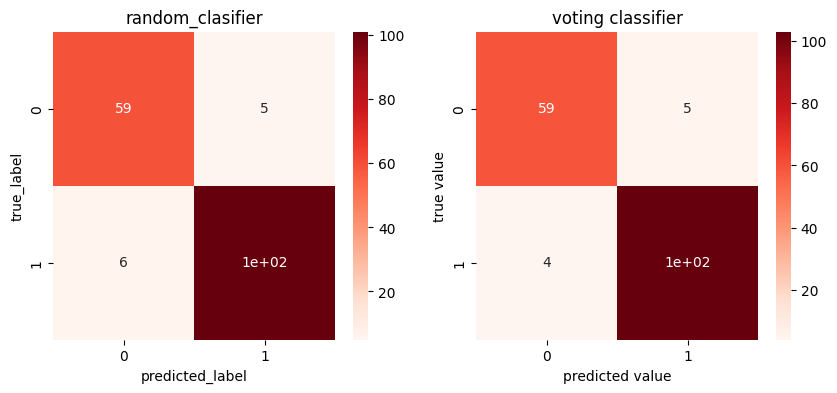

In [276]:
y_prede=random_model.predict(x_test)
fig,ax=plt.subplots(1,2,figsize=(10,4))
matrix=confusion_matrix(y_test,y_prede)
sns.heatmap(matrix,annot=True,cbar=True,cmap='Reds',ax=ax[0])
ax[0].set_title('random_clasifier')
ax[0].set_xlabel('predicted_label')
ax[0].set_ylabel('true_label')
predicted_value=voting_clf.predict(x_test)
matrix_value=confusion_matrix(y_test,predicted_value)
sns.heatmap(matrix_value,annot=True,cbar=True,cmap='Reds',ax=ax[1])
ax[1].set_title('voting classifier')
ax[1].set_xlabel('predicted value')
ax[1].set_ylabel('true value')

plt.show()

In [277]:
def final_pred(y_test,predicted_value):
    #lets see the other score for it 
    f1=f1_score(y_test,predicted_value)
    acc=accuracy_score(y_test,predicted_value)
    prec=precision_score(y_test,predicted_value)
    print(f'f1_score={f1} \n  acc_score={acc} \n prec_Score={prec}')

In [278]:
predicted_value=voting_clf.predict(x_test)
final_pred(y_test,predicted_value)

f1_score=0.958139534883721 
  acc_score=0.9473684210526315 
 prec_Score=0.9537037037037037


In [279]:
def feature_imp(random_model,data):
    # now lets check the usefullness of the feature used on the 
    importances=random_model.best_estimator_.feature_importances_
    names=data.feature_names 
    feature_importance_df = pd.DataFrame({
        'Feature': names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Plotting
    plt.figure(figsize=(20, 12))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(64))
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()

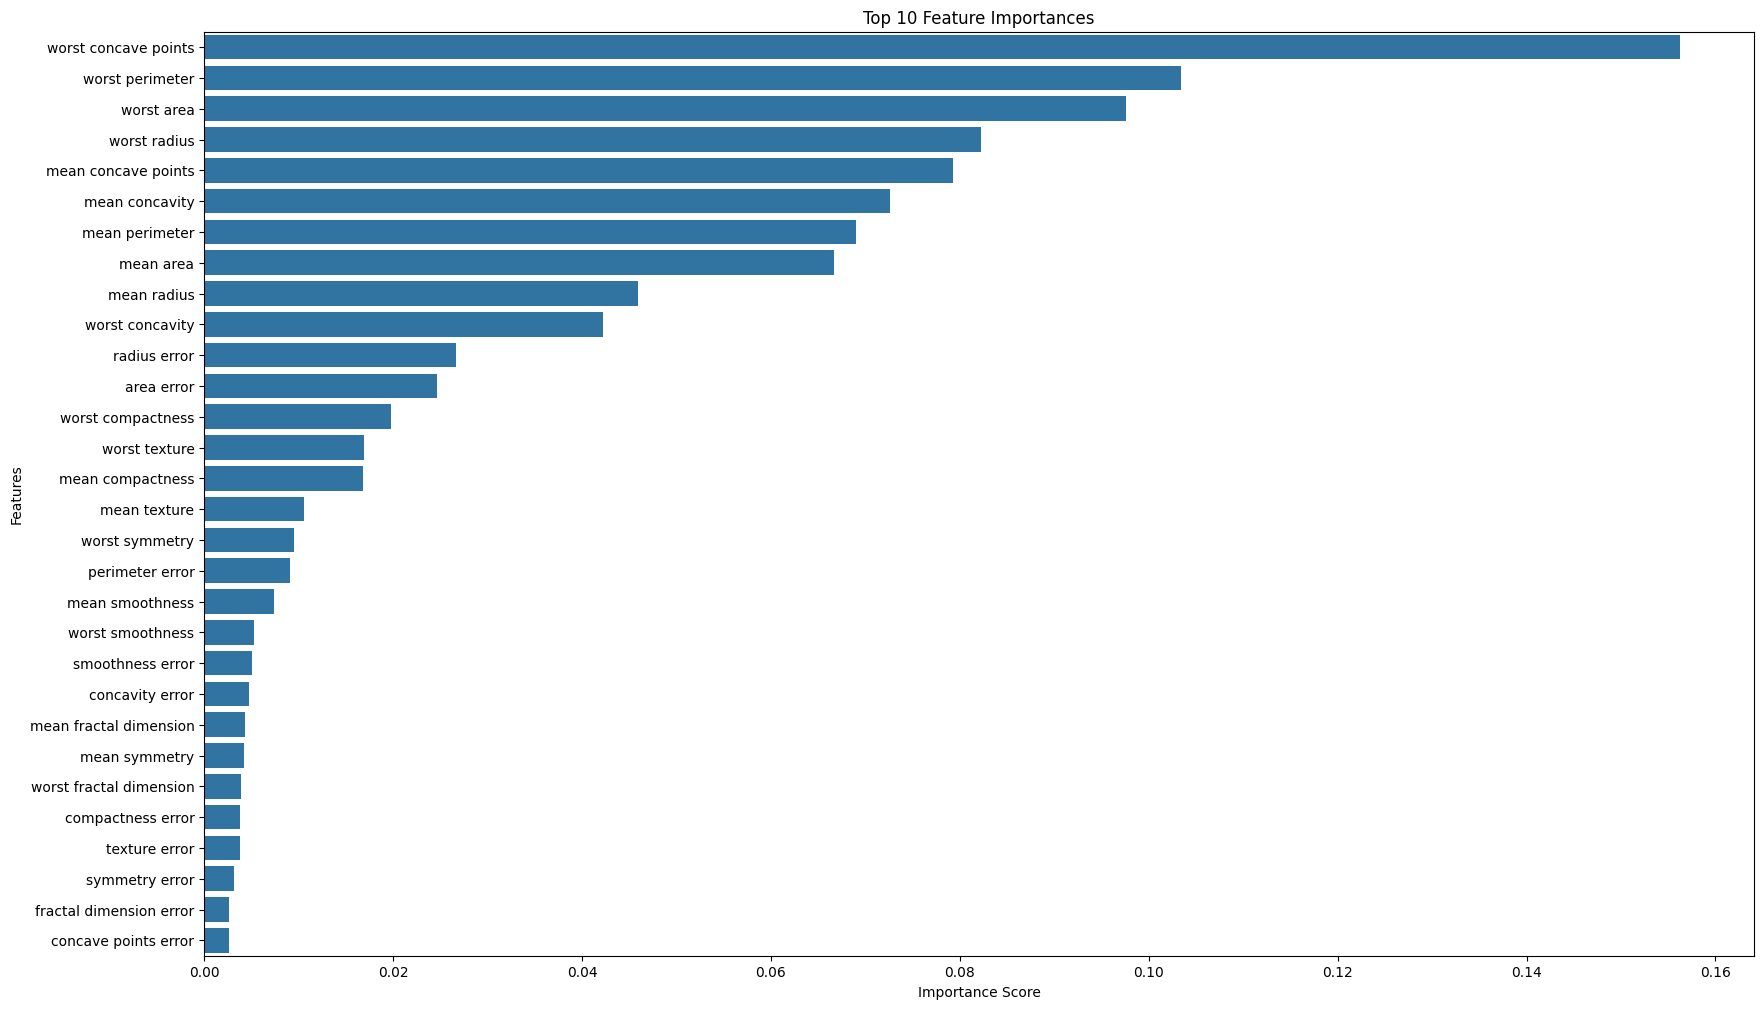

In [280]:
feature_imp(random_model,data)

In [281]:
#lets remove the feature with least importance and see the performence of the model 
data1=pd.DataFrame(data.data,columns=data.feature_names)
colm=['mean symmetry', 'smoothness error', 'mean smoothness', 'concave points error','texture error','symmetry error' ,'fractal dimension error','mean fractal dimension','compactness error' ,'concavity error']
data1=data1.drop(columns=colm)
x_value=data1.to_numpy()
x_train,x_test,y_train,y_test=data_splitter(x_value,y_value)
random_model=random_forest_clasifier(x_train,y_train)
random_scores(random_model,x_test,y_test)
gradient_model=gradient_bost_classifier(x_train,y_train)
voting_clf=voting_classifier(random_model,gradient_model,x_train,y_train)
predicted_value=voting_clf.predict(x_test)
print(' \n \n \n .....................................................')
final_pred(y_test,predicted_value)

<class 'numpy.ndarray'>
Fitting 5 folds for each of 10 candidates, totalling 50 fits
final_parameter={'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'entropy'} 
 final_score= 0.9684206434086275 

f1_score=0.9585253456221198 
  acc_score=0.9473684210526315 
 prec_Score=0.9454545454545454
Fitting 5 folds for each of 10 candidates, totalling 50 fits
final_parameter={'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 6, 'criterion': 'squared_error'} 
 final_score= 0.9599871900712241 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
 
 
 
 .....................................................
f1_score=0.963302752293578 
  acc_score=0.9532163742690059 
 prec_Score=0.9459459459459459
